In [1]:
import time as t
import numpy as np
import matplotlib.pyplot as plt 

import qiskit
from qiskit.visualization import *
import qiskit_machine_learning as qml
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import EfficientSU2
import qiskit.circuit as Q

import torch
from torch import cat, no_grad, manual_seed
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Parameter,
)
import torch.nn.functional as F
import math

from utils import gtt, make_filt

In [2]:
epochs = 10  # Set number of epochs
filt, digits = make_filt(None)
# filt, digits = make_filt([0,1,3,5,6])

qubits = digits
n_train = 200*digits

print(f'using {qubits} |> @{n_train} points ∈ {filt} for {epochs} epochs')
train_loader, test_loader = gtt(n_train, filt, batch_size=1)

using 10 |> @2000 points ∈ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] for 10 epochs


In [3]:
def ansat(prefix):
    ansatz = EfficientSU2(2, su2_gates=['rz'], entanglement='linear', reps=1, parameter_prefix=prefix)
    return ansatz
qubits = 4
shots = 512

backend = qiskit.Aer.get_backend('aer_simulator')

In [167]:
def QConvCircuit(qubits):
    params = [Q.Parameter(f"rx_{i}") for i in range(0,qubits)]
    all_q = [i for i in range(qubits)]

    qc = Q.QuantumCircuit(qubits, 1)

    qc.h(all_q)
    for i in all_q: qc.rx(params[i], i)
    for i in all_q: qc.cx(i, (i+1)%4)

    qc.barrier()
    qc.compose(ansat('a'), qubits=[0,1], inplace=True)
    qc.compose(ansat('b'), qubits=[2,3], inplace=True)
    qc.crx(Q.Parameter('mp_11'), 0,1)
    qc.crx(Q.Parameter('mp_12'), 2,3)
    qc.barrier()

    qc.compose(ansat('c'), qubits=[1,3], inplace=True)    
    qc.crx(Q.Parameter('mp_21'), 1,3)
    qc.barrier()

    qc.measure(3,0)
    qc = qiskit.compiler.transpile(qc, optimization_level=3)
    
    return qc, params

In [192]:
class QConv(Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.qc, self.params = QConvCircuit(qubits)
        
        # PARAMETERS TO STORE WEIGHTS ONLY
        self.weights = [c for c in self.qc.parameters if c.name[0]!="r"] 
        # Remove the inputs from weights s.t. inputs are rx_i
        
        self.kern_dicts = [
            {
               h: np.random.rand() for h in self.weights
            } for i in range(out_channels)
        ]

    @staticmethod
    def forward(self, x):
        _, height, width = x.shape
        output_height = height - 2
        output_width = width - 2
        
        output = torch.zeros(self.out_channels, output_height, output_width)

        for kernId,kern in enumerate(self.kern_dicts): # for each kernel
            print(kernId)
            for i in range(output_height): # loop over images
                for j in range(output_width):
                    block = x[:, i:i+2, j:j+2].flatten(start_dim=1)
                    block_angles = block / 255 * 2 * torch.pi - torch.pi # rx_i inputs
                    
                    # initialise inputs
                    params_dict = dict(zip(self.params, block_angles.flatten().tolist()))
                    params_dict.update(kern) # add the weights to the circuit params
                    
                    bc = self.qc.assign_parameters(params_dict)
                    
                    q_output = qiskit.execute(bc, backend, shots=512).result().get_counts()
                    output[kernId, i, j] = q_output['1']
                    
        return output
    
    def backward(self, grad_output):
    batch_size, height, width = self.input_shape
    
    # Create zero gradient tensor for input x
    grad_x = np.zeros_like(self.x)
    
    for kernId, kern in enumerate(self.kern_dicts): # for each kernel
        for i in range(height - 2): # loop over images
            for j in range(width - 2):
                # Flatten the 2x2 block into a 1D tensor
                block = self.x[:, i:i+2, j:j+2].reshape(batch_size, -1)
                
                # Compute gradients for each qiskit parameter
                for param in self.params:
                    grads = np.zeros_like(block)
                    for p_idx in range(block.size):
                        # Compute gradient for this specific parameter
                        param_dict = dict(zip(self.params, block.flatten()))
                        param_dict.update(kern)
                        param_dict[param] += np.pi / 255.
                        # Apply a forward pass on a circuit with only this parameter changed
                        bc = self.qc.assign_parameters(param_dict)
                        q_output = qiskit.execute(bc, backend, shots=512).result().get_counts()
                        # Update the gradient tensor with the computed gradient
                        grads[p_idx] = (q_output['1'] - self.output[kernId, i, j]) / (2 * np.pi / 255.)
                    # Reshape the gradient tensor back to 2x2 shape and add it to the grad_x tensor
                    grads = grads.reshape(batch_size, 2, 2)
                    grad_x[:, i:i+2, j:j+2] += grads * grad_output[kernId, i, j]
    
    return grad_x

In [193]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = QConv(1)
        self.conv2 = QConv(1)
        self.fc = Linear(25, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = MaxPool2d(kernel_size=2)(x)
        x = self.conv2(x)
        x = MaxPool2d(kernel_size=2)(x)
        x = x.view(1, -1)
        x = self.fc(x)
        return x

In [194]:
model = Net()
print(model)
print(model(torch.randn(1,28,28)))

Net(
  (conv1): QConv()
  (conv2): QConv()
  (fc): Linear(in_features=25, out_features=10, bias=True)
)
0
0
tensor([[ -97.8214,  106.8174,  245.8011,  191.4290, -260.1871,   69.5751,
         -229.5763, -115.5377,   69.1743,   63.7736]],
       grad_fn=<AddmmBackward0>)


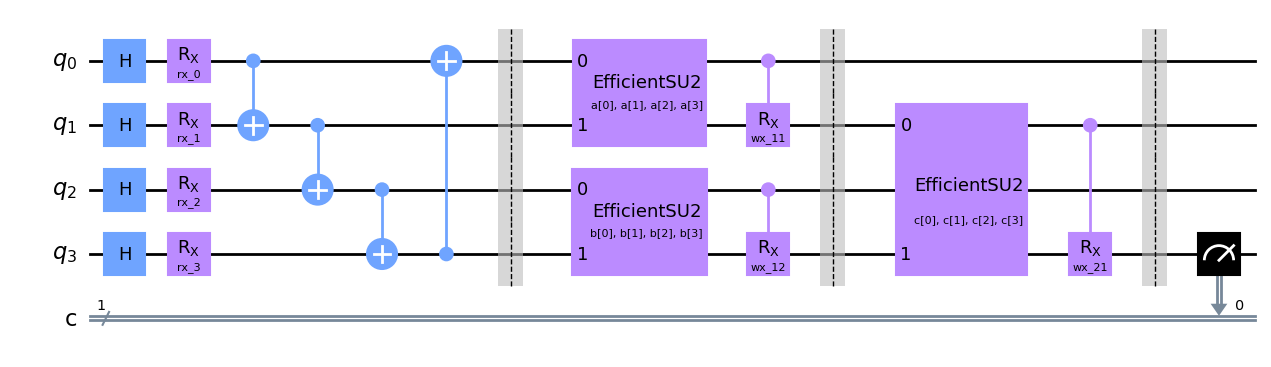

In [185]:
params = [Q.Parameter(f"rx_{i}") for i in range(0,qubits)]
all_q = [i for i in range(qubits)]
qc = Q.QuantumCircuit(qubits, 1)

qc.h(all_q)
for i in all_q:
    qc.rx(params[i], i);
for i in all_q:
    qc.cx(i,(i+1)%4)

qc.barrier()
qc.compose(ansat('a'),qubits=[0,1], inplace=True)
qc.compose(ansat('b'),qubits=[2,3], inplace=True)
qc.crx(Q.Parameter("wx_11"), 0,1)
qc.crx(Q.Parameter("wx_12"), 2,3)
qc.barrier()

qc.compose(ansat('c'),qubits=[1,3], inplace=True)    
qc.crx(Q.Parameter("wx_21"), 1, 3)
qc.barrier()

qc.measure(3,0)

qc.draw('mpl')

In [5]:
inputs = np.random.randn(4).astype(np.float16)
circ = Conv2x2(inputs)

weights = np.random.rand(len(circ.parameters))
print(weights)

bound = circ.assign_parameters({param: np.round(np.random.rand(),4) for param in circ.parameters})

result = qiskit.execute(circ, backend, shots=shots).result().get_counts()
one = result['1']/shots
print(f"PROB of 1: {one}")
bound.draw("mpl")

NameError: name 'Conv2x2' is not defined

In [ ]:
# Define model, optimizer, and loss function
optimizer = Adam(model4.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.99)

loss_func = CrossEntropyLoss()

# Start training
loss_list = [2.3]  # Store loss history
model4.train()  # Set model to training mode

itrs = len(train_loader)
logspan = int(itrs*44/100) # 12%

print(f"Running training for {qubits} Qubits @{itrs} itrs/epoch")

In [ ]:
for epoch in range(epochs):
    total_loss = []
    times = []
    now = t.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        z = t.time()
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        z = t.time() - z;
        if ((batch_idx%(logspan))==0): print(f"{int(z)*logspan} sec/{logspan}itrs")
    
    scheduler.step()
    end = int((t.time() - now)/60)+1
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Trained [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]), 
          f"in {end} min \t(<{int((epochs-epoch-1)*end)} min left)")
    
    diff = np.abs(loss_list[-1] - loss_list[-2]) /loss_list[-1]; 
    if diff <= 0.0005: # Early stopping criterial loss diff = 0.1%
        print("Τraining Complete")
        break;

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
model4.eval()
with torch.no_grad():
    
    correct = 0
    for (data, target) in test_loader:
        output = model4(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
                sum(total_loss) / len(total_loss),
                correct / len(test_loader) * 100)
            )
    print(f"\tRandom: {int(100/digits)}%")

In [ ]:
# Plot predicted labels

n_samples_show = 15
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for (data, target) in test_loader:
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="viridis")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("{}".format(pred.item()))

        count += 1

In [47]:
from IPython.core.display import HTML
HTML("""
<style>
html{filter:invert(0.86)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")